Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [3]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

def tokenize(text):
    "Complete this function"
    
    return [token for token in simple_preprocess(text) if token in STOPWORDS]

In [4]:
import os

# tokenize data function
def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [5]:
tokens = gather_data(path)

In [6]:
tokens[0][0:10]

['by', 'and', 'with', 'and', 'seemed', 'to', 'some', 'of', 'the', 'of']

In [7]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

## Follow Along

In [9]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [10]:
len(titles)

813

In [11]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [12]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

In [13]:
len(tokens)

813

### Author DataFrame


In [14]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [15]:
df.head()

,tokens
Austen_Emma0000,"[by, and, with, and, seemed, to, some, of, the..."
Austen_Emma0001,"[she, were, here, again, what, it, is, that, e..."
Austen_Emma0002,"[all, every, was, every, in, their, not, and, ..."
Austen_Emma0003,"[of, and, of, which, for, the, last, two, or, ..."
Austen_Emma0004,"[some, of, the, had, you, have, of, the, has, ..."


In [16]:
df['tokens'].head()

Austen_Emma0000    [by, and, with, and, seemed, to, some, of, the...
Austen_Emma0001    [she, were, here, again, what, it, is, that, e...
Austen_Emma0002    [all, every, was, every, in, their, not, and, ...
Austen_Emma0003    [of, and, of, which, for, the, last, two, or, ...
Austen_Emma0004    [some, of, the, had, you, have, of, the, has, ...
Name: tokens, dtype: object

In [17]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [18]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [19]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [48]:
df.shape

(813, 4)

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [21]:
# read up on yield statement later, this is a stretch goal
# this allows us to not crash the computer since we avoid loading tons of docs into memory
# gensim can work with generators but also arrays and lists, etc. 
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(str(text))
                yield tokens

In [22]:
streaming_data = doc_stream(path)

In [23]:
type(streaming_data) 

generator

In [ ]:
# gather_data => returns a list
# doc_stream => returns a generator

In [ ]:
next(streaming) # Returns one document at a time from the generator

### Gensim LDA Topic Modeling

In [54]:
# A Dictionary Representation of all the words in our corpus
# id2word is a standard convention
# manual here: https://radimrehurek.com/gensim/corpora/dictionary.html
id2word = corpora.Dictionary(doc_stream(path))
type(id2word)

gensim.corpora.dictionary.Dictionary

In [55]:
id2word.token2id['england'] 

3986

In [56]:
id2word[869]

'degree'

In [57]:
id2word.doc2bow(tokenize("THis is a sample message Darcy England England Darcy"))

# the only thing that remains in memory after our stream is this id2word list of tuples

[(2753, 1), (3986, 2), (6601, 1), (6818, 2)]

In [58]:
import sys
sys.getsizeof(id2word)

56

In [59]:
len(id2word.keys()) # this is the length of our list of tuples that remains after

22095

In [60]:
# Let's remove extreme values from the dataset
# their workflow is you use this after putting in stream
# equivalent to setting min and max df 
id2word.filter_extremes(no_below=5, no_above=0.95)

In [61]:
len(id2word.keys())

8102

In [62]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [64]:
type(corpus)

list

In [63]:
# so corpus is a list of tuples of (wordID, count)
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 4),
 (7, 1),
 (8, 1),
 (9, 1)]

In [65]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [68]:
# required args are the corpus, the id2word dictionary, random state is apparently unreliable
# passes is the most time costly one, for sprint challenge go ahead and put passes at like 2 lol
# default is like 100 passes lol 
# workers is the cores thing, still go and look up enabling SMT again on this machine

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [54]:
# only shows limited number of topics sorted by descending, probabilities look super low since
# each doc has thousands of words and each has a probability 
lda.print_topics()

[(0,
  '0.009*"pounds" + 0.007*"mother" + 0.006*"sure" + 0.006*"think" + 0.006*"year" + 0.004*"rochester" + 0.004*"certainly" + 0.004*"thornfield" + 0.004*"fairfax" + 0.004*"live"'),
 (1,
  '0.008*"pelet" + 0.005*"thought" + 0.005*"like" + 0.004*"little" + 0.004*"man" + 0.004*"hunsden" + 0.004*"time" + 0.003*"having" + 0.003*"pupils" + 0.003*"crimsworth"'),
 (2,
  '0.008*"madame" + 0.006*"little" + 0.006*"like" + 0.004*"day" + 0.004*"vous" + 0.004*"thought" + 0.003*"know" + 0.003*"beck" + 0.003*"good" + 0.003*"paul"'),
 (3,
  '0.005*"night" + 0.005*"look" + 0.005*"like" + 0.004*"old" + 0.004*"est" + 0.004*"looked" + 0.003*"sir" + 0.003*"thought" + 0.003*"house" + 0.003*"hunsden"'),
 (4,
  '0.007*"little" + 0.005*"madame" + 0.005*"like" + 0.004*"thought" + 0.004*"know" + 0.004*"hand" + 0.004*"good" + 0.004*"night" + 0.003*"day" + 0.003*"dr"'),
 (5,
  '0.017*"elizabeth" + 0.013*"darcy" + 0.010*"miss" + 0.010*"bingley" + 0.010*"bennet" + 0.009*"jane" + 0.007*"know" + 0.007*"think" + 0.006

In [76]:
# list comprehension to clean up the . . . quotations? 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [77]:
# filter top 5 topics 
topics = [' '.join(t[0:5]) for t in words]

In [63]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
pounds mother sure think year

------ Topic 1 ------
pelet thought like little man

------ Topic 2 ------
madame little like day vous

------ Topic 3 ------
night look like old est

------ Topic 4 ------
little madame like thought know

------ Topic 5 ------
elizabeth darcy miss bingley bennet

------ Topic 6 ------
know jane life like long

------ Topic 7 ------
frances monsieur hunsden little english

------ Topic 8 ------
good little like emma elton

------ Topic 9 ------
sir long jane rochester little

------ Topic 10 ------
like little rochester miss room

------ Topic 11 ------
emma miss harriet thing weston

------ Topic 12 ------
jane emma little thing miss

------ Topic 13 ------
elinor marianne sister mother time

------ Topic 14 ------
monsieur henri georgiana mdlle little



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [66]:
# helps visualize topics 
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [69]:
# LDA was first used in genetic mining
pyLDAvis.gensim.prepare(lda, corpus, id2word, sort=True)

# returns a graph that reduces them to circles on an XY grid
# 1 is the largest and then descending

# sliding relevance metric down adjusts to weigh more to the topic (closer to 0) instead of everything (closer to 1)
# usually we care about at 1
# this is nice for something like EDA but isn't what we need to answer the business question how similar are these 2 

C:\Users\benjamin\Anaconda3\envs\U4-S1-NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.086109 -0.006008       1        1  41.976734
2      0.096106  0.014838       2        1  19.396456
4      0.069379 -0.064267       3        1  11.418595
7     -0.123732 -0.057420       4        1   8.034630
0      0.113208 -0.084783       5        1   4.911840
11     0.103097 -0.091142       6        1   4.027915
5      0.114385  0.018410       7        1   3.994269
14     0.103918  0.106251       8        1   1.489573
1     -0.011588  0.029208       9        1   1.013518
8     -0.097039 -0.021388      10        1   0.999455
3     -0.142886  0.006040      11        1   0.770559
9      0.073180  0.104523      12        1   0.767098
12    -0.028002 -0.056611      13        1   0.646021
6     -0.102658  0.024924      14        1   0.297359
13    -0.081258  0.077425      15        1   0.255978, topic_info=     Category         Freq       Term        Total  loglift  logprob
403   Default  1327.000000       like  1327.000000  30.0000  30.0000
159   Default  1716.000000     little  1716.000000  29.0000  29.0000
183   Default  1508.000000       miss  1508.000000  28.0000  28.0000
399   Default  1421.000000       know  1421.000000  27.0000  27.0000
86    Default   819.000000       emma   819.000000  26.0000  26.0000
280   Default  1130.000000    thought  1130.000000  25.0000  25.0000
372   Default  1344.000000       good  1344.000000  24.0000  24.0000
1339  Default   648.000000  elizabeth   648.000000  23.0000  23.0000
284   Default  1311.000000       time  1311.000000  22.0000  22.0000
148   Default   907.000000       jane   907.000000  21.0000  21.0000
279   Default  1298.000000      think  1298.000000  20.0000  20.0000
168   Default   896.000000        man   896.000000  19.0000  19.0000
5851  Default   700.000000     elinor   700.000000  18.0000  18.0000
447   Default   918.000000      shall   918.000000  17.0000  17.0000
186   Default   668.000000     mother   668.000000  16.0000  16.0000
1012  Default   499.000000    harriet   499.000000  15.0000  15.0000
987   Default   640.000000       eyes   640.000000  14.0000  14.0000
1537  Default   622.000000       john   622.000000  13.0000  13.0000
260   Default   922.000000       soon   922.000000  12.0000  12.0000
1444  Default   618.000000       hand   618.000000  11.0000  11.0000
337   Default   829.000000       come   829.000000  10.0000  10.0000
63    Default  1062.000000        day  1062.000000   9.0000   9.0000
753   Default   779.000000        saw   779.000000   8.0000   8.0000
450   Default   591.000000        sir   591.000000   7.0000   7.0000
611   Default   655.000000      young   655.000000   6.0000   6.0000
135   Default   758.000000      house   758.000000   5.0000   5.0000
5031  Default   415.000000      darcy   415.000000   4.0000   4.0000
99    Default   495.000000     father   495.000000   3.0000   3.0000
129   Default   654.000000      heart   654.000000   2.0000   2.0000
4998  Default   321.000000     bennet   321.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
252   Topic15     3.510835    sisters   183.252274   2.0128  -5.4317
553   Topic15     2.946128      marry   199.985474   1.7501  -5.6070
1924  Topic15     1.497752  explained    45.041832   2.5642  -6.2836
5023  Topic15     2.347612       mary   149.415680   1.8145  -5.8341
2127  Topic15     1.765780    journey    78.769653   2.1699  -6.1189
3973  Topic15     1.261881     repeat    34.438480   2.6613  -6.4549
585   Topic15     1.771567      shook    85.910110   2.0864  -6.1157
1174  Topic15     1.772577       free    87.570679   2.0678  -6.1151
1700  Topic15     1.189161     labour    31.219847   2.7000  -6.5143
4572  Topic15     2.351255         st   196.422150   1.5425  -5.8326
3841  Topic15     1.191191       sign    33.393391   2.6344  -6.5126
403   Topic15     4.289869       like  1327.897339   0.2327  -5.2313
227

### Overall Model / Documents

In [66]:
# these add up to one now and most of the really low ones became zero
lda[corpus[0]]

[(10, 0.13784581), (11, 0.7755074), (13, 0.084544025)]

In [67]:
# list comp loop over corpus 
distro = [lda[d] for d in corpus]

In [70]:
distro[0]

[(10, 0.13785432), (11, 0.7755409), (13, 0.08450204)]

In [71]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [72]:
len(new_distro)

813

In [73]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[by, and, with, and, seemed, to, some, of, the...",1,Emma,0
Austen_Emma0001,"[she, were, here, again, what, it, is, that, e...",1,Emma,1
Austen_Emma0002,"[all, every, was, every, in, their, not, and, ...",1,Emma,2
Austen_Emma0003,"[of, and, of, which, for, the, last, two, or, ...",1,Emma,3
Austen_Emma0004,"[some, of, the, had, you, have, of, the, has, ...",1,Emma,4


In [78]:
distro_df = pd.DataFrame.from_records(new_distro, index=titles)
distro_df.columns = topics
distro_df['author'] = distro_df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [79]:
distro_df.head()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle,author
Austen_Emma0000,0.000000,0.0,0.234596,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.763396,0.000000,0.0,0.0,Austen
Austen_Emma0001,0.339843,0.0,0.000000,0.0,0.427915,0.000000,0.0,0.0,0.0,0.0,0.0,0.229988,0.000000,0.0,0.0,Austen
Austen_Emma0002,0.669674,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.328062,0.000000,0.0,0.0,Austen
Austen_Emma0003,0.191043,0.0,0.000000,0.0,0.000000,0.806826,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,Austen
Austen_Emma0004,0.485297,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.106017,0.406838,0.0,0.0,Austen


In [82]:
distro_df.groupby('author').mean()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle
author,,,,,,,,,,,,,,,
Austen,0.103894,0.006975,0.428147,0.000000,0.21189,0.088537,0.000000,0.000283,0.001807,0.017822,0.013387,0.086676,0.004560,0.000028,0.033303
CBronte,0.003979,0.012633,0.007977,0.013696,0.03634,0.003922,0.005369,0.137128,0.015777,0.000056,0.746284,0.001337,0.007101,0.004740,0.001008


In [81]:
type(distro_df.groupby('author').mean())

pandas.core.frame.DataFrame

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [83]:
# in the good old days we'd select topics arbitrarily 
# kind of based on intuition of subject matter experts
# which has led us to modern coherence model metrics 
# 

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [84]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [85]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [80]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.603344,2,0
1,-0.859198,8,0
2,-0.821042,14,0
3,-0.710456,20,0
4,-0.843094,26,0


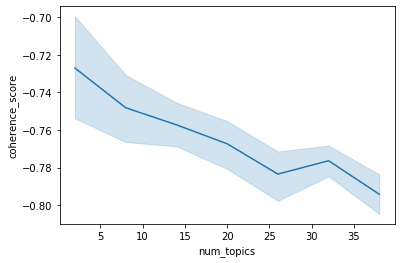

In [82]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [86]:
# Print the coherence scores
# This vaguely seems wasteful since we can just look at topic_coherence 
x = range(2, 40, 6)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

TypeError: type dict doesn't define __round__ method

In [ ]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [85]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [86]:
test = "Ned asked me a question about England today."

In [87]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [88]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [89]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [ ]:
%pwd

In [90]:
people = get_people(doc_stream(path))

In [ ]:
list(people)[:50]

In [ ]:
gender_lookup = {'Adele':'female_charc', 'William Crimsworth':'male_charc'}

In [ ]:
doc = nlp(next(doc_stream(path)))

In [ ]:
doc.ents[0].lemma_

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)